# One Pixel Attack Tutorial
## Part 2 - ImageNet

### Dan Kondratyuk
### March 22, 2018

[Part 1](1_one-pixel-attack-cifar10.ipynb)

This time around, we will demonstrate the one pixel attack on ImageNet. The images are 224x224 px in size, with 1000 classes to pick from.

## Imports

Ensure that you have `numpy`, `pandas`, `scipy`, `matplotlib`, `tensorflow-gpu`, and `keras` installed.

In [1]:
# Python Libraries
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import keras
from keras import backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.applications.imagenet_utils import decode_predictions, preprocess_input

# Helper functions
import helper
from attack import PixelAttacker

matplotlib.style.use('ggplot')
np.random.seed(100)

## Load Dataset

### Download ImageNet Images

To begin, we will demonstrate an attack on one image. The code below will download images from the specified URLs and save to the `data` directory. You may also add more ImageNet URLs, which can be obtained from http://image-net.org/download-imageurls.

In [2]:
with open('data/imagenet_classes.pkl', 'rb') as f:
    class_names = pickle.load(f)
word_to_class = {w:i for i,w in enumerate(class_names)}

In [3]:
# Image URLs given by ImageNet
urls = [
    'http://farm4.static.flickr.com/3154/2585091536_78f528fdee.jpg',
]

# Where each file will be saved to
filenames = [
    'data/balloon.jpg'
]

# The labels of each corresponding image
labels = [
    word_to_class['balloon']
]

In [4]:
# Download all image files
for url, filename in zip(urls, filenames):
    print('Downloading', filename)
    helper.download_from_url(url, filename)

39.5kB [00:00, 809kB/s]


Let's see what the image looks like. The code below will load an image of a balloon into memory and convert it into a `numpy` array.

In [5]:
originals = [load_img(filename, target_size=(224, 224)) for filename in filenames] # Load an image in PIL format
images = np.array([img_to_array(original) for original in originals]) # Convert the PIL image to a numpy array

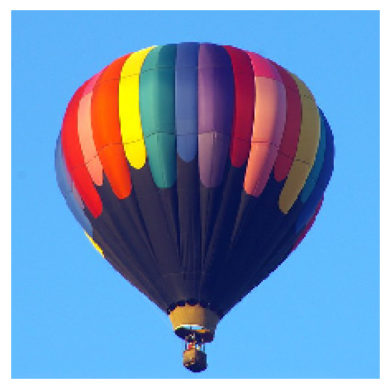

In [6]:
helper.plot_image(images[0])

## Load Model

Keras conveniently supplies pretrained weights for several ImageNet models. We will use `MobileNet` (~30 MB). Running the cell below will initiate a download of the model weights if it is not cached already.

In [ ]:
import tensorflow
model = tensorflow.keras.applications.MobileNet()

Now, predict the image's class.

In [ ]:
from tensorflow.keras.preprocessing import images
processed_images = preprocess_input(images.copy()) # Prepare the image for the model
predictions = model.predict(processed_images) # Get the predicted probabilities for each class
label = decode_predictions(predictions) # Convert the probabilities to class labels

label

We see that the model correctly predicts `balloon` with 99.7% confidence.

## Perturb Image

Like before, we can perturb an image by changing the color of one or more pixels. The cell below will modify the center pixel to be yellow. As the images are much larger in size than in Cifar10, this change will be barely noticable.

In [ ]:
pixel = np.array([112, 112, 255, 255, 0]) # pixel = x,y,r,g,b
image_perturbed = helper.perturb_image(pixel, images)
helper.plot_image(image_perturbed[0])

Let's see what the model now predicts.

In [ ]:
preprocessed_perturbed = preprocess_input(image_perturbed.copy())
predictions = model.predict(preprocessed_perturbed)
label = decode_predictions(predictions)

label

The model still predicts balloon, but the perturbation did manage to change the confidence slightly.

## Attack

Finally, we use differential evolution to conduct the attack to see what percentage of images we can successfully cause the model to misclassify in a reasonable amount of time.

It is recommended to use Keras with a GPU enabled. The code below can be used to check (if using TensorFlow).

In [ ]:
# Should output /device:GPU:0
K.tensorflow_backend._get_available_gpus()

In [ ]:
models = [model]

test = processed_images, np.array([labels])

attacker = PixelAttacker(models, test, class_names, dimensions=(224, 224))

In [ ]:
result = attacker.attack(0, model, maxiter=20, verbose=True)

In this instance, the attack was not successful. The model still correctly predicts balloon. However, the above output shows that the attack does indeed lower the confidence of the model. If we have a larger dataset, we can see more easily how many of the images in the dataset can be attacked successfully.

### TODO: Attack with more images

In [ ]:
# predictions = model.predict(attack_image)
# label = decode_predictions(predictions)
# label